In [146]:
# Importing the necessary packages
import numpy as np                                  # "Scientific computing"


import pandas as pd                                 # Data Frame

import matplotlib.pyplot as plt                     # Basic visualisation
import seaborn as sns                               # Advanced data visualisation

from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [147]:
# Read the dataset
df = pd.read_csv('https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets//clothes_size_prediction.csv')
df.head()

,weight,age,height,size
0,62,28.0,172.72,XL
1,59,36.0,167.64,L
2,61,34.0,165.10,M
3,65,27.0,175.26,L
4,62,45.0,172.72,M


## Data Analyse & Cleaning

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119734 entries, 0 to 119733
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   weight  119734 non-null  int64  
 1   age     119477 non-null  float64
 2   height  119404 non-null  float64
 3   size    119734 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


In [149]:
df = df.dropna()

We merken op dat er te weinig velden zijn voor XXL. Deze gaan we droppen.

In [150]:
df['size'].value_counts()

M       29575
S       21829
XXXL    21259
XL      19033
L       17481
XXS      9907
XXL        69
Name: size, dtype: int64

In [151]:
df = df[df['size'] != 'XXL']
df['size'].value_counts()

M       29575
S       21829
XXXL    21259
XL      19033
L       17481
XXS      9907
Name: size, dtype: int64

We willen stratified sampling toepassen op de leeftijdsvariabele. We willen de leeftijd van iedere consument aanpassen naar het dichtste vijfvoud. Wel moeten we rekening houden met de datatypes van de variabelen.

In [152]:
df['height'] = df['height'].astype('int')

In [153]:
df['age'] = round(df['age'] / 5)
df['age'] = df['age'].astype('int')

We gaan alle duplicate rijen uit de dataset halen. Dit doen we met drop_duplicates, maar bij het droppen van een duplicate moeten we meegeven welke waarde er moet worden behouden.
1. We sorteren de waarden eerst op basis van alle features: weight, age, height en size.
2. We droppen alle duplicates en we behouden de eerste. Andere opties zijn 'last' en False. Bij False worden alle duplicaten verwijderd, dus niets wordt behouden.

In [154]:
df = df.sort_values(by = ['weight','age','height','size'])
df = df.drop_duplicates(keep='first')

We willen hoeveel records er zijn met dezelfde waarden voor gewicht, age en height. Echter moeten deze waarden een verschillende size hebben. Hier werken we met een groupby.

De waarden voor Size zullen nu veranderen naar numerieke waarden.

In [155]:
temp = df.groupby(['weight','age','height']).agg('nunique').reset_index()

In [156]:
df = df.drop_duplicates(subset=['weight','age','height'],keep='first')

We willen weten of we met een skewed dataset zitten. Dit wilt zeggen dat de dataset niet uit gelijke frequenties bestaat. 
* Een dataset met drie klassen die elke 50 waarden hebben is niet skewed.
* Een dataset met drie klassen waarvan één klasse 150 waarden heeft en de andere 300 en de andere maar 20 is skewed. 

In [157]:
df['size'].value_counts()

XXXL    1747
L       1695
M        672
XL       517
S        377
XXS      141
Name: size, dtype: int64

We merken op dat het aantal XXXL en L maten overrepresentatief zijn. We gaan ad-random 1/3de van elk uit de dataset halen. We moeten rekening houden dat dit werkelijk ook ad-random is.

1. Een techniek om dit te doen is op basis van random. We gaan een willekeurig getal aan iedere rij toekennen. We hebben op oog om alle rijen met waarde 0 te gaan verwijderen.
2. We verwijderen alle rijen die de waarde 0 hebben én ofwel XXXL/L zijn.
3. De variabele random hebben we niet meer nodig, dus die gaan we weer verwijderen.

In [158]:
import random
df['random'] = [random.randint(0,2) for k in df.index]
df.head(20)

,weight,age,height,size,random
19379,22,6,167,L,0
9986,22,9,152,XXXL,2
69879,26,9,172,XXXL,2
11986,31,7,175,XXXL,1
40013,35,4,182,XXXL,2
81610,36,4,157,XXS,0
88001,38,4,147,XXS,0
79608,38,6,152,XXS,1
105639,39,5,160,XXS,1
104382,39,7,160,S,2


In [159]:
filterMoetXXXLzijn = (df['random'] == 0) & (df['size'] == 'XXXL')
filterMoetLzijn = (df['random'] == 0) & (df['size'] == 'L')
filterMagNietIetsAndersZijn = (df['size'] != 'L') & (df['size'] != 'XXXL')

df = df[(filterMoetLzijn | filterMoetXXXLzijn | filterMagNietIetsAndersZijn)]

In [160]:
df = df.drop(['random'],axis=1)

## Te zoeken waarde gaan veranderen naar een numerieke waarde.

We kunnen ons model niet compilen met tekstwaarden als onze te zoeken waarde. We moeten waarden zoals 'XXXL' gaan aanpassen naar een numerieke waarde.
1. We maken een dictionary aan van alle mogelijke klassen. We koppelen iedere klasse aan een numeriek getal van 0-5.

In [161]:
mapdict = {'XXS':0,'S':1, 'M': 2, 'L': 3,'XL':4,'XXXL': 5}
df['size'] = df['size'].map(mapdict)
df.head()

,weight,age,height,size
19379,22,6,167,3
81610,36,4,157,0
88001,38,4,147,0
79608,38,6,152,0
105639,39,5,160,0


## Model opbouwen

1. We halen de X en y waarden op.
2. We splitsen de dataset in een training- en testset.

In [162]:
X = df.drop(['size'],axis=1)
y = df['size']

In [163]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

## Feature scaling

Bij classifiers en regressiemodellen moeten wij rekening houden met de schaalbaarheid van de waarden. We moeten rekening houden met de vele mogelijkheden van waarden voor bepaalde variabelen. Dit kunnen we oplossen met feature scalers. Hieronder werken we een MinMaxScaler uit binnen een ColumnTransformer.

1. We willen achterhalen wat de numerieke kolommen zijn in het dataframe.
2. We bouwen de ColumnTransformer op.

In [164]:
numerical_ix = X.select_dtypes(include=['int32','int64','float64']).columns

In [165]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
numerical_ix = X.select_dtypes(include=['int32','int64','float64']).columns

col_transform = ColumnTransformer(transformers=[
    ('std_scaler',StandardScaler(), numerical_ix)
    ])

## Regressie

We gaan een lineair model uitwerken voor deze dataset. Dit doen we met gebruik van een Pipeline om alle stappen met elkaar te laten opvolgen.

1. We bouwen het Lineaire Regressiemodel op.
2. We definiëren de structuur van de Pipeline. Deze is vrij klein, maar het principe geldt dat we eerst de kolommen gaan aanpassen of transformeren. Daarna gaan we het lineaire regressiemodel toepassen.
3. We trainen het model en geven er de bijhorende nauwkeurigheidsscores op. Opmerking: Hier krijgen wij drie coëfficienten te zien. Dit duidt aan dat we met drie features zitten.
4. We evalueren het model aan de hand van RMSE of MAE.

In [166]:
from sklearn.linear_model import  LinearRegression
lin_reg = LinearRegression()

In [167]:
pipeline = Pipeline([
    ('prep', col_transform),
    ('lin_reg', lin_reg)
    ])

In [168]:
pipeline.fit(X_train,y_train)

from sklearn.model_selection import cross_val_score
-np.mean(cross_val_score(pipeline,X_train,y_train,scoring='neg_mean_squared_error',cv=5))

0.8013322164243732

In [169]:
y_predict = pipeline.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test,y_predict,squared=False)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test,y_predict)

print(f'MSE: {mse}')
print(f'MAE: {mae}')

MSE: 0.9313608314766058
MAE: 0.713234493105422


### Regressie: Extra

Hier willen we gebruik maken van drie modellen: lineaire regressie, ridge regressie en SGDRegressie.

1. We instantiëren de modellen. Bij Ridge en SGD moeten we een random_state meegeven. De drie modellen slaan wij op in een dictionary.
2. We doorlopen de dictionary van modellen. Een model in een dictionary is opgeslaan onder een key en een item. Met een for-lus doorlopen we de dictionary. In deze for-lus gaan wij een pipeline aanmaken voor ieder model. Deze gaan we gaan trainen met de X en y van de trainingset. Voor ieder model gaan wij de MAE en de RMSE gaan berekenen.

In [170]:
from sklearn.linear_model import Ridge, SGDClassifier

lin_reg = LinearRegression()
ridge_reg = Ridge(random_state=42)
sgd_reg = SGDClassifier(random_state=42)

all_reg = {
  "lin_reg  ": lin_reg,
  "ridge_reg": ridge_reg, 
  "sgd_reg  ": sgd_reg
  }

In [171]:
for key, model in all_reg.items():
  pipeline = Pipeline(
    [
      ("coltr", col_transform), 
      (key, model)
      ])
      
  pipeline.fit(X_train, y_train)
  
  y_pred = pipeline.predict(X_test)
  mae = cross_val_score(pipeline, X_train, y_train, cv=3, scoring="neg_mean_squared_error").mean()
  mse = mean_absolute_error(y_test, y_pred)

  print(f"{key}\tMAE-cross validation = {-mae}\tMAE-test set = {mse}")

lin_reg  	MAE-cross validation = 0.7999575563127305	MAE-test set = 0.713234493105422
ridge_reg	MAE-cross validation = 0.7999528634821451	MAE-test set = 0.7132690209122531
sgd_reg  	MAE-cross validation = 1.6144967682363804	MAE-test set = 0.9058171745152355


### Regressie: Extra over Polynomiale features

We willen kijken wat het effect is van het aantal graden van een veelterm op de dataset. Hiervoor moeten we gebruik maken van polynomiale features.

1. Zelfde stap als daarnet. Nu hebben wij enkel een lineaire regressiemodel nodig en een model voor de polynomiale features. Echter kunnen wij deze nu nog niet aanmaken, want voor de verschillende veeltermen zal deze anders zijn.
2. We voeren een for-lus uit waarbij we het aantal graden gaan verhogen met één. Nu kunnen we wél een object voor de polynomiale features gaan aanmaken. We geven de teller mee als variabele. 
2. In de pipeline gaan we drie objecten meegeven: de columntransformer, de polynomiale features en als laatst het lineaire model.
2. We fitten de pipeline met de trainingsdata en we bouwen een array van voorspelde waarden op.
2. We gebruiken de voorspelde waarden om de MAE en de RMSE te berekenen. De MAE moet je (net zoals daarnet) negatief gaan plaatsen. Anders krijg je een negatieve waarde terug.

In [172]:
from sklearn.preprocessing import PolynomialFeatures

degrees = [i for i in range(1, 10)]
lin_reg = LinearRegression()

In [173]:
for i in degrees:
  poly = PolynomialFeatures(degree=i)
  pipeline = Pipeline(
    [
        ("coltr", col_transform),
        ("poly", poly),
        ("lin_reg", lin_reg)
        ])

  X_train_poly = pipeline.fit(X_train, y_train)

  y_pred = pipeline.predict(X_test)

  mae = cross_val_score(pipeline, X_train, y_train, cv=3, scoring="neg_mean_squared_error").mean()
  mse = mean_absolute_error(y_test, y_pred)

  print(f"degree = {i}\tMAE-cross validation = {-mae}\tMAE-test set = {mse}")

degree = 1	MAE-cross validation = 0.7999575563127305	MAE-test set = 0.713234493105422
degree = 2	MAE-cross validation = 0.6473935798049153	MAE-test set = 0.6018611498796045
degree = 3	MAE-cross validation = 0.6355659483750825	MAE-test set = 0.582572449846652
degree = 4	MAE-cross validation = 0.6448126896290541	MAE-test set = 0.5787724957738504
degree = 5	MAE-cross validation = 0.9123828485395714	MAE-test set = 0.5792820319829155
degree = 6	MAE-cross validation = 1.1481750545087166	MAE-test set = 0.6013705394706593
degree = 7	MAE-cross validation = 8.405355883269664	MAE-test set = 0.6174287072126694
degree = 8	MAE-cross validation = 71.32981755142033	MAE-test set = 0.6680444326385157
degree = 9	MAE-cross validation = 63473.059801619944	MAE-test set = 1.1592321168657151


## Classificatie

1. Voor de eerste classifier gaan we werken met een softmax classifier. Hiervoor werken we met een logistic regression object, maar met de multi_class op 'multinomiaal'.
2. We bouwen de pipeline op met daarin (opnieuw) de columntransformer en het softmax model.
3. We trainen de pipeline o.b.v. de trainingsdata.
4. We vragen de accuracyscore op door de geteste labels en de voorspelde labels mee te geven. (spoiler: slechte score incoming)
5. We bouwen de confusion matrix op én geven die visueel weer.

In [174]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

softmax = LogisticRegression(multi_class="multinomial")

pipeline = Pipeline(
    [
        ("perp", col_transform), 
        ("softmax", softmax)
    ])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)

Text(91.68, 0.5, 'Actual class')

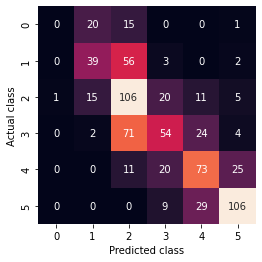

In [175]:
from sklearn.metrics import confusion_matrix

cnf = confusion_matrix(y_test, y_pred)
labels = ["0","1", "2", "3", "4", "5"]
cf = sns.heatmap(cnf,square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
cf.set_xlabel('Predicted class')
cf.set_ylabel('Actual class')